In [1]:
from game import Game
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
s = Game(**{'obstacles':2, 'jupyter':1, 'nn':0, 'vision':True})

p1_list = []
p2_list = []
p1_ps = s.get_state(0)[0]
p2_ps = s.get_state(1)[0]
for i in range(100):
    ns = s.step({'p1':0,'p2':0})
    p1_ps = s.get_state(0)#(s.get_state(0) + p1_ps * 0.94).clip(0, 1)
    p2_ps = s.get_state(1)#(s.get_state(1) + p1_ps * 0.94).clip(0, 1)
    p1_list.append(p1_ps)
    p2_list.append(p2_ps)

s.end()

In [3]:
p1_list[0].shape

(1, 280, 120, 3)

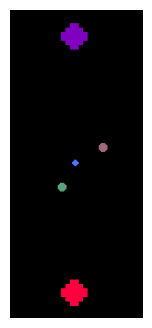

In [4]:
plt.figure(figsize=(6, 4))
plt.imshow(p1_list[0][0])
plt.axis('off')          # hide axis ticks
plt.show()

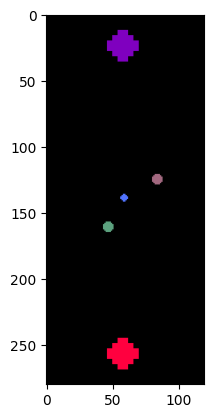

In [5]:
fig, ax = plt.subplots()
img_display = ax.imshow(p1_list[0][0])
def update_frame(i):
    img_display.set_data(p1_list[i][0])
    return [img_display]
ani = animation.FuncAnimation(fig, update_frame, frames=len(p1_list), interval=1)
HTML(ani.to_jshtml())

In [1]:
from tinygrad import Tensor, nn, TinyJit, dtypes
from tinygrad.nn.state import safe_save, safe_load, get_state_dict, load_state_dict, get_parameters

In [ ]:
def _process_batch(self, batch, **cfg):
        states, actions, rewards, next_states, dones = zip(*batch)
        states_t = Tensor(np.vstack(states), dtype=dtypes.half).reshape(-1, 3, 280, 120)
        next_states_t = Tensor(np.vstack(next_states), dtype=dtypes.half).reshape(-1, 3, 280, 120)
        rewards_t = Tensor(np.vstack(rewards), dtype=dtypes.half)
        dones_t = Tensor(np.vstack(dones), dtype=dtypes.int16)
        actions_t = Tensor(np.vstack(actions), dtype=dtypes.int16)

        # minibatch_size = actions.shape[0]

        # Get Q-values for current states and next_states
        target = self.model(states_t) # Nx280x120x3 -> Nx5
        q_val = self.target_model(next_states_t) # Nx280x120x3 -> Nx5
        # print(target[0].numpy())
        # print(q_val[0].numpy())
        # This is the Q-Value update step where we are approximating the current reward and future rewards
        # Rewards is given by the state of the board at next_state
        # The discount factor increases as time goes on so the values learned over time get more important
        # The Q-Value gets compounded more into the future as epsilon decreases
        # GG - if the next_state was a game over there is no q_val for the future
        #       |  R  | + |Dis| * |       Q Val       | * |         GG        |
        # q_val = rewards + GAMMA * np.max(q_val, axis=1) * (1 - np.array(dones))
        q_val = rewards_t + GAMMA * q_val.max(axis=1).reshape(-1, 1) * (1 - dones_t.reshape(-1, 1))
        # assert q_val.shape == (minibatch_size, 1), f"{q_val.shape} should be {(minibatch_size, 1)}"

        # vectorized lazy q-value update method
        mask = actions_t.argmax(1).one_hot(5)
        # assert mask.shape == (states.shape[0], 5), f"Mask shape was improper for mask: {mask.shape}"

        # pre_dim = target.shape
        target += mask * (1-Q_VAL_RATIO) * target + mask * Q_VAL_RATIO * q_val
        # assert pre_dim == target.shape, f"target shape mismatch - expected: {pre_dim}, got: {target.shape}"

        # train on minibatch
        # assert target.shape[0] == states.shape[0], 'batch dims dont match'
        # assert target.shape == (minibatch_size, 5), f'target shape improper {target.shape}'
        # assert states.shape == (minibatch_size, 3, 280, 120), f'states shape improper {states.shape}'

        # print('Data information:')
        # print(f'targets: ', target.max().numpy(), target.min().numpy())
        # print(f'rewards: ', rewards.max().numpy(), rewards.min().numpy())
        # print(f'q_vals: ', q_val.max().numpy(), q_val.min().numpy())
        # print(f'states: ', states.max().numpy(), states.min().numpy())
        # print(f'actions: ', actions.max().numpy(), actions.min().numpy())

        # print(f'targets: ', target[0].numpy())
        # print(f'rewards: ', rewards[0].numpy())
        # print(f'q_vals: ', q_val[0].numpy())
        # print(f'states: ', states[0].numpy())
        # print(f'actions: ', actions[0].numpy())
        # import sys 
        # sys.exit(0)
        train(self.model, np.vstack(states).reshape(-1, 3, 280, 120), target.numpy(), self.model.opt, 5, BATCH_SIZE, mae)

In [2]:
# test_inp = Tensor(p1_list[0], dtype=dtypes.half).reshape(-1, 3, 280, 120)
test_inp = Tensor.rand((1,3,280,120), dtype=dtypes.half)
test_inp.shape

(1, 3, 280, 120)

In [3]:
tst = Tensor.randint((32, 5))
tst.argmax(1).realize().numpy()

array([2, 1, 2, 4, 0, 2, 2, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 3, 0, 4, 2,
       2, 4, 0, 1, 3, 0, 0, 3, 1, 0], dtype=int32)

In [4]:
Tensor([2]).one_hot(5).realize().numpy()


array([[0, 0, 1, 0, 0]], dtype=int32)

In [5]:
DROPOUT = 0.3

In [6]:
def model_shape(model, x):
    txs = [x.shape]
    names = ['input']
    params = 0
    for l in model.layers:
        if isinstance(l, nn.Conv2d) or isinstance(l, nn.Linear) or isinstance(l, nn.BatchNorm):
            print(f'{l.__class__.__name__}:')
            print(f"\tWeights: {l.weight.shape}")
            t = l.weight.shape[0]
            for d in l.weight.shape[1:]:
                t *= d
            params += t
        else:
            print(f'Activation: {l.__name__}')
        pre = x.shape
        x = l(x)
        post = x.shape
        if len(pre) != len(post) or sum([pre[i] != post[i] for i in range(len(pre))]) > 0:
            print(f'\ttransformation: {pre} -> {post}')
            names.append(l.__name__ if hasattr(l, '__name__') else l.__class__.__name__)
            txs.append(post)

    print(f'Total parameters: {params}')
    print('Transformations:\n -', end=' ')
    print('\n - '.join([f"{n}:\t{t}" for t, n in zip(txs, names)]))

In [7]:
def conv_block(inp, outp, ks:int|tuple=3, s:int=1, p:int|tuple=0, act=Tensor.relu, p_ks=(2,2), p_s:int=None, p_pad:int|tuple=0):
    return [
        nn.Conv2d(inp, outp, ks, stride=s, padding=p), act,
        lambda x: x.dropout(DROPOUT), nn.BatchNorm(outp), 
        lambda x: x.max_pool2d(p_ks, p_s, padding=p_pad),
    ]
# Tensor.max_pool2d()
def lin_block(inp, outp, act=Tensor.relu):
    return [nn.Linear(inp, outp), act, lambda x: x.dropout(DROPOUT)]

# input dims: (N, 280, 120, 3)
# idea: merge 2 or 3 together | (N, 280, 360, 9)

class Model:
    def __init__(self):
        self.layers = [
            *conv_block(3, 16, (3,3), p=1, p_ks=(2,2)),          # 280 x 120 x 3 -> 140 x 60 x n
            *conv_block(16, 32, (3,3), p=(0,1), p_ks=(3,3)),     # 70 x 60 x n -> 46 x 20 x 2n
            *conv_block(32, 64, (3,3), p=(0,1), p_ks=(2,2)),    # 46 x 20 x 2n -> 22 x 10 x 4n
            *conv_block(64, 128, (3,3), p=(0,1), p_ks=(4,2)),    # 22 x 10 x 4n -> 5 x 5 x 8n
            *conv_block(128, 256, (3,3), p_ks=(3,3)),            # 5 x 5 x 8n -> 1 x 1 x 16n
            lambda x: x.flatten(1),
            *lin_block(256, 64),
            nn.Linear(64, 5), 
            Tensor.dropout,
            Tensor.softmax,
        ]
    
    def __call__(self, x: Tensor) -> Tensor: 
        return x.sequential(self.layers)
    
    def save(self, filename='model.tnsr'):
        state_dict = get_state_dict(self)
        safe_save(state_dict, filename)

    def load(self, filename='model.tnsr'):
        state_dict = safe_load(filename)
        load_state_dict(self, state_dict)
        return self

    def clone(self):
        new = Model()
        self.save('tmp.tnsr')
        new.load('tmp.tnsr')
        import os
        os.remove('tmp.tnsr')
        return new



In [8]:
m = Model()
model_shape(m, test_inp)

Conv2d:
	Weights: (16, 3, 3, 3)
	transformation: (1, 3, 280, 120) -> (1, 16, 280, 120)
Activation: relu
Activation: <lambda>
BatchNorm:
	Weights: (16,)
Activation: <lambda>
	transformation: (1, 16, 280, 120) -> (1, 16, 140, 60)
Conv2d:
	Weights: (32, 16, 3, 3)
	transformation: (1, 16, 140, 60) -> (1, 32, 138, 60)
Activation: relu
Activation: <lambda>
BatchNorm:
	Weights: (32,)
Activation: <lambda>
	transformation: (1, 32, 138, 60) -> (1, 32, 46, 20)
Conv2d:
	Weights: (64, 32, 3, 3)
	transformation: (1, 32, 46, 20) -> (1, 64, 44, 20)
Activation: relu
Activation: <lambda>
BatchNorm:
	Weights: (64,)
Activation: <lambda>
	transformation: (1, 64, 44, 20) -> (1, 64, 22, 10)
Conv2d:
	Weights: (128, 64, 3, 3)
	transformation: (1, 64, 22, 10) -> (1, 128, 20, 10)
Activation: relu
Activation: <lambda>
BatchNorm:
	Weights: (128,)
Activation: <lambda>
	transformation: (1, 128, 20, 10) -> (1, 128, 5, 5)
Conv2d:
	Weights: (256, 128, 3, 3)
	transformation: (1, 128, 5, 5) -> (1, 256, 3, 3)
Activation: 

In [ ]:
m.save()

In [9]:
m(test_inp).realize().numpy()

array([[0.17675415, 0.20516019, 0.20214337, 0.19272703, 0.22321521]],
      dtype=float32)

In [ ]:
lm = Model().load()
lm(test_inp).realize().numpy()

In [ ]:
cp_m = lm.clone()
cp_m(test_inp).realize().numpy()

In [ ]:
@TinyJit
@Tensor.train()
def train_step(x: Tensor, y: Tensor, model: Model, opt: nn.optim.AdamW) -> Tensor:
    opt.zero_grad()
    loss = model(x)(y).backward()
    return loss.realize(*opt.schedule_step())


In [ ]:
for _ in range(100):
    train_step(test_inp, Tensor([0,1,0,0,0]), lm, nn.optim.Adam(nn.state.get_parameters(lm)))

In [ ]:
lm(test_inp).realize().numpy() - cp_m(test_inp).realize().numpy()

In [ ]:
get_parameters(m)

In [ ]:
m.layers